In [1]:
%matplotlib widget

import sys
sys.path.append("..")

from utils.plot import plot_volume, plot_stack
from utils.dicom import read_series, normalize_hu
from utils.utils import load
from utils.cv import combine, denoise, renoise, min_max_normalize, crop
from utils.remove_bed import bed_mask
import cv2 as cv
import numpy as np
from typing import Tuple, List
from tqdm import tqdm

infos = load("/data/covid_ct/train_infos.pkl")
paths = [[item.replace("/home/peter", "") for item in info["lung"]] for info in infos]

interactive(children=(IntSlider(value=1, description='val', max=279, min=1), Output()), _dom_classes=('widget-…

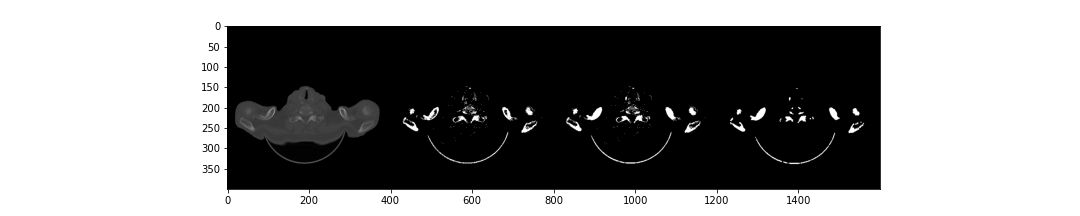

In [24]:
item_index = 17
sample = read_series(paths[item_index])


def proc_slice(img: np.ndarray) -> Tuple[np.ndarray, ...]:
    mask = bed_mask(img)
    img = np.where(mask, img, -1024)
    legal = np.count_nonzero(img) > 0
    if legal:
        upper_thres = 250
    else:
        upper_thres = 1
    threshold = np.where(img < upper_thres, 0, 255).astype(np.uint8)
    # cleaned_threshold = denoise(threshold, total_iter=1)
    contours = cv.findContours(threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)[0]
    contour_img = np.zeros_like(threshold)
    cv.drawContours(contour_img, contours, -1, 255, cv.FILLED)
    cleaned_threshold = denoise(contour_img, kernel_size=2)
    return normalize_hu(img), threshold, contour_img, cleaned_threshold


plot_volume(np.array([combine(proc_slice(img)) for img in sample]), size=15)


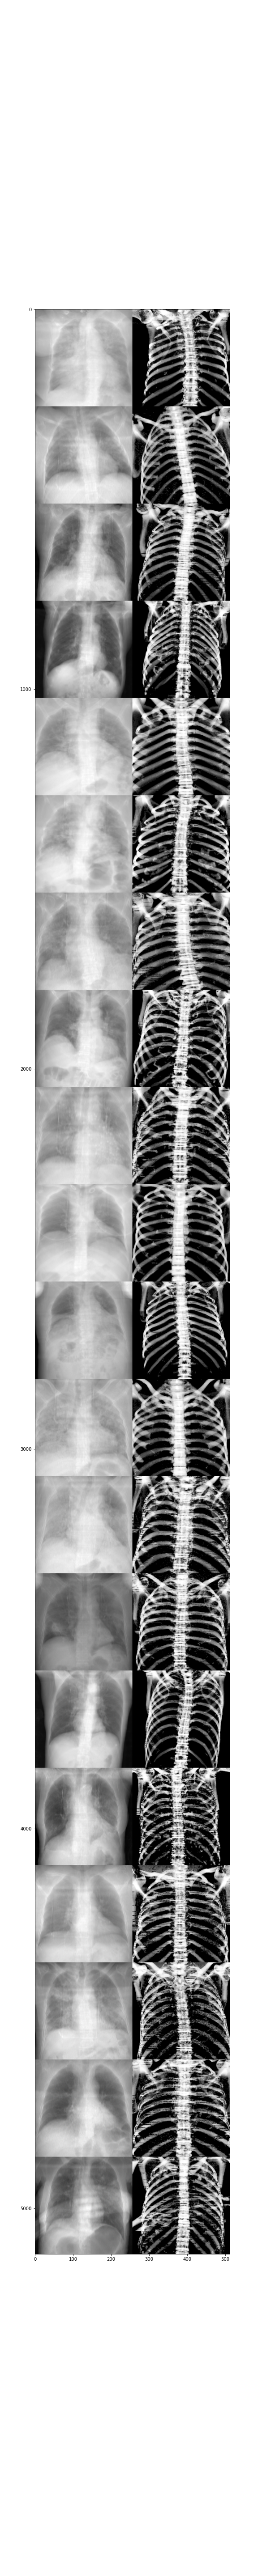

In [25]:
def proc_volume(paths: List[str]) -> Tuple[np.ndarray, ...]:
    volume = read_series(paths)
    slices = np.array([proc_slice(volume[i])[3] for i in range(volume.shape[0])])

    original_projection = crop(min_max_normalize(np.sum(volume, axis=1)), size=256)
    masked_projection = cv.equalizeHist(crop(min_max_normalize(np.sum(slices, axis=1)), size=256))

    return original_projection, masked_projection

results = np.array([combine(proc_volume(path)) for path in paths[:20]])
plot_stack(results, axis=0)

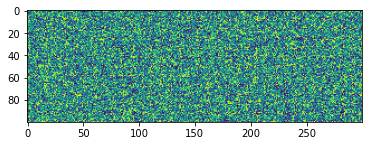

In [1]:
import matplotlib.pyplot as plt
import numpy as np

img = np.random.randint(low=0, high=255,size=(100,300))
plt.imshow(img)